Initial conditions: simulations are initialized with the wavenumber-2 solution to the linearized system


∂ₜK + ∂ₓK = -1/√2 ̄HA


∂ₜR - 1/3*∂ₓR = -2√2/3 ̄HA


∂ₜQ + ̄Q/√2∂ₓK - Q/6√2∂ₓR = (̄Q/6 - 1)̄HA


∂ₜA = ΓQ<Aₛ>

In [1]:
using DataStructures
using Distributions
using FFTW
using Interpolations
using LinearAlgebra
using Measures
using MultivariateStats
using PyPlot
using Random


In [2]:
include("params/params.jl")

1×64 Matrix{Float64}:
 0.0279778  0.0253689  0.023118  …  0.0374344  0.0341435  0.0309183

define matrix for the eigenproblem

In [34]:
# The wavenumber-2 eigenmode is selected to initialize model.
k=2;
κ2= 2*π*im*2/L;
Mat = -im.*[κ2           0.0           0.0                1/√2*Hbar;
            0.0         -1/3.0*κ2      0.0                2*√2/3.0*Hbar;
            Qbar/√2*κ2  -Qbar/6/√2*κ2  0.0               -(Qbar/6.0- 1.0)*Hbar;
            0.0          0.0           -Γ*(mean(Aₛ[1,:], dims=1))/γ         0.0];
                      
d, V = eigen(Mat); # eignevalues (frequencies) in ascending order

#select MJO mode (slowest eastward propagating wave of the model)
MJO_vec= V[:,3];


In [35]:
initampl = 0.05; 

K0 = zeros(Nx, 1).*im;
R0 = zeros(Nx, 1).*im;
Q0 = zeros(Nx, 1).*im;
Z0 = zeros(Nx, 1).*im;
A0 = zeros(Nx, 1).*im;

xx = collect(0:Nx-1)*dx;
yy = range(-3,3, length = 40);
phi0 = γ.*exp.(-yy.^2 ./2.0);
phi2 = γ.*1.0/√2 .* (2.0.*yy.^2 .-1.0) .*exp.(-yy.^2 ./2.0);

    
K0[:,1] += initampl*MJO_vec[1]*exp.(κ2*xx);
R0[:,1] += initampl*MJO_vec[2]*exp.(κ2*xx);
Q0[:,1] += initampl*MJO_vec[3]*exp.(κ2*xx);
A0[:,1] += initampl*MJO_vec[4]*exp.(κ2*xx); 


K0_ref =K0;
R0_ref =R0;
Q0_ref =Q0;
A0_ref =A0;


K0 = real(K0);
R0 = real(R0);
Q0 = real(Q0);
A0 = real(A0);

a = A0' .* phi0; #.*15.0*24.0/8.0*Hbar
q = Q0' .* phi0;
theta = -1/√2 * (K0' .+ R0'./2.0).*phi0 .- R0'./4.0.*phi2 ;
p = -theta;

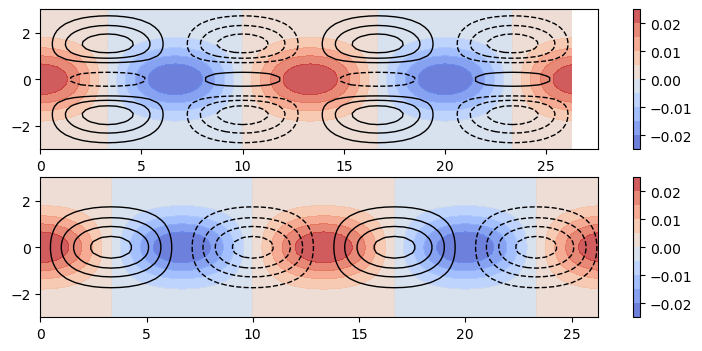

PyObject <matplotlib.colorbar.Colorbar object at 0x7fee9d68a7e0>

In [36]:
#a = ifelse.((a .> 0.004) .| (a .< -0.004), a, Inf)

fig = figure(figsize = (9,4))
gs = fig.add_gridspec(2,1)

element(i,j) = get(gs, (i,j))
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)

xxx = xx'.*ones(40);
yyy = yy .* ones(Nx)';


ax1 = fig.add_subplot(element(0,0))
ax2 = fig.add_subplot(element(1,0))

ax1.contour(xxx, yyy, p, colors = "k", linewidths = 1, levels = 8).collections[5].remove()
cfp1 = ax1.contourf(xxx, yyy, a, cmap = PyPlot.cm[:coolwarm], alpha = 0.8, levels = 11)
cbar = fig.colorbar(cfp1, ax = ax1)

ax2.contour(xxx, yyy, q, colors = "k", linewidths = 1, levels = 8).collections[6].remove()
cfp2 = ax2.contourf(xxx, yyy, a, cmap = PyPlot.cm[:coolwarm], alpha = 0.8,  levels = 11)
cbar = fig.colorbar(cfp1, ax = ax2)

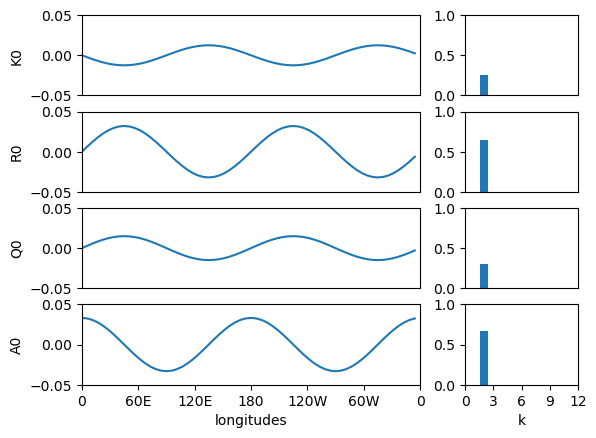

In [37]:
fig = plt.figure()

gs = fig.add_gridspec(4, 2, width_ratios=[3, 1])
element(i,j) = get(gs, (i,j))
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)


ax11 = fig.add_subplot(element(0,0))
ax12 = fig.add_subplot(element(0,1))
ax21 = fig.add_subplot(element(1,0))
ax22 = fig.add_subplot(element(1,1))
ax31 = fig.add_subplot(element(2,0))
ax32 = fig.add_subplot(element(2,1))
ax41 = fig.add_subplot(element(3,0))
ax42 = fig.add_subplot(element(3,1))

########################################
ax11.plot(longitudes, K0)
ax21.plot(longitudes, R0)
ax31.plot(longitudes, Q0)
ax41.plot(longitudes, A0)

ax11.set_ylim([-0.05,0.05])
ax21.set_ylim([-0.05,0.05])
ax31.set_ylim([-0.05,0.05])
ax41.set_ylim([-0.05,0.05])

ax11.set_xlim([0,360])
ax21.set_xlim([0,360])
ax31.set_xlim([0,360])
ax41.set_xlim([0,360])

ax11.set_ylabel("K0")
ax21.set_ylabel("R0")
ax31.set_ylabel("Q0")
ax41.set_ylabel("A0")

ax11.xaxis.set_ticks([])
ax21.xaxis.set_ticks([])
ax31.xaxis.set_ticks([])
ax41.xaxis.set_ticks([])
ax41.xaxis.set_ticks([0, 60, 120, 180,240, 300, 360])
ax41.xaxis.set_ticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]) ;

ax41.set_xlabel("longitudes");

############################################################################


ax12.bar(k, norm(MJO_vec[1]))
ax22.bar(k, norm(MJO_vec[2]))
ax32.bar(k, norm(MJO_vec[3]))
ax42.bar(k, norm(MJO_vec[4]))

ax12.set_xlim([0,12])
ax22.set_xlim([0,12])
ax32.set_xlim([0,12])
ax42.set_xlim([0,12])

ax12.set_ylim([0,1])
ax22.set_ylim([0,1])
ax32.set_ylim([0,1])
ax42.set_ylim([0,1])

ax12.xaxis.set_ticks([])
ax22.xaxis.set_ticks([])
ax32.xaxis.set_ticks([])
ax42.xaxis.set_ticks([0,3,6,9,12])

ax42.set_xlabel("k");


# SAVE SOLUTION

In [38]:
# variables to save (ts)
K0_ts = K0_ref;
R0_ts = R0_ref;
Q0_ts = Q0_ref*γ;
A0_ts = A0_ref*γ .+ real.(mean(Aₛ[:,:], dims = 1)[1,:]);
theta = -1/√2 * (K0_ts .+ R0_ts./2.0).*γ .+ R0_ts./4.0.*γ./√2 ; 
Z0_ts = Q0_ts .+ Qbar.*theta;

In [23]:
save("./initial_conditions/initial_conditions.jld", "K0", K0_ts, "R0", R0_ts, "Q0", Q0_ts, "A0", A0_ts, "Z0", Z0_ts)